In [2]:
import numpy as np
import pandas as pd
from likeness import check_smiles_validity
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np

## Read XML

In [7]:
"""
The data provided by DrugBank is given in the format of XML so we need to first read and parse the .xml file to extract the 
relevant information to DDI.
"""

def process_drugbank_to_dataframe(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'ns': 'http://www.drugbank.ca'}
    data = []
    for drug in root.findall('ns:drug', namespace):
        primary_id = None
        for drugbank_id in drug.findall('ns:drugbank-id', namespace):
            # We take primary drugbank-id as our 1st Drug ID because it is in the correct format to be mapped to BindingDB
            if drugbank_id.attrib.get('primary') == 'true': 
                primary_id = drugbank_id.text
                break

        # If no primary ID is found, skip this drug entry
        if not primary_id:
            continue

        # Extract name and description
        name = drug.find('ns:name', namespace)
        description = drug.find('ns:description', namespace)
        primary_name = name.text if name is not None else 'N/A'
        primary_description = description.text if description is not None else 'N/A'

        # For each drug there is a list of drug-interaction pairings each with different description
        interactions = drug.find('ns:drug-interactions', namespace)

        # We skip drug entries that have no DDI records
        if interactions:
            for interaction in interactions.findall('ns:drug-interaction', namespace):
                interacting_drug_id = interaction.find('ns:drugbank-id', namespace).text
                interacting_drug_name = interaction.find('ns:name', namespace).text
                interaction_description = interaction.find('ns:description', namespace).text

                data.append({
                    'primary_id': primary_id,
                    'primary_name': primary_name,
                    'primary_description': primary_description,
                    'interacting_drug_id': interacting_drug_id,
                    'interacting_drug_name': interacting_drug_name,
                    'interaction_description': interaction_description
                })

    df = pd.DataFrame(data)
    multi_index_df = df.set_index(['primary_id', 'interacting_drug_id'])

    return multi_index_df

file_path = '../../data/drugbank/drugbank.xml'
ddi = process_drugbank_to_dataframe(file_path)
ddi = ddi.reset_index()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4880fc9e10>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [5]:
def extract_smiles_from_drugbank(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'ns': 'http://www.drugbank.ca'}
    data = []
    
    for drug in root.findall('ns:drug', namespace):
        drugbank_id = drug.find('ns:drugbank-id[@primary="true"]', namespace)
        if drugbank_id is None:
            continue
        primary_id = drugbank_id.text
        
        smiles_element = drug.find('ns:calculated-properties/ns:property[ns:kind="SMILES"]/ns:value', namespace)
        smiles = smiles_element.text if smiles_element is not None else 'N/A'
        
        data.append({
            'DrugBank ID': primary_id,
            'SMILES': smiles
        })
    
    df = pd.DataFrame(data)
    return df

file_path = '../../data/drugbank/drugbank.xml'
db_smiles = extract_smiles_from_drugbank(file_path)
db_smiles = db_smiles.reset_index()

In [6]:
ddi.to_csv('../../data/ddi.csv')
db_smiles.to_csv('../../data/db_smiles.csv')

## BioBert for Labeling

In [11]:
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans

In [4]:
ddi = pd.read_csv('../../data/ddi.csv')
ddi.head()

,Unnamed: 0,primary_id,interacting_drug_id,primary_name,primary_description,interacting_drug_name,interaction_description
0,0,DB00001,DB06605,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,Apixaban,Apixaban may increase the anticoagulant activi...
1,1,DB00001,DB06695,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,Dabigatran etexilate,Dabigatran etexilate may increase the anticoag...
2,2,DB00001,DB01254,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,Dasatinib,The risk or severity of bleeding and hemorrhag...
3,3,DB00001,DB01609,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,Deferasirox,The risk or severity of gastrointestinal bleed...
4,4,DB00001,DB01586,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,Ursodeoxycholic acid,The risk or severity of bleeding and bruising ...


In [5]:
"""
Experimental approach to cluster the interaction description of DDI.
We use BioBert (a pretrained BERT model on biological texts) to extract the context appropriate embeddings for out descriptions.
Then we apply K-Means to cluster the embeddings into three clusters which later are interpretated as 'Major', 'Moderate' or 'Minor' 
sensitivity.
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to(device)
texts = ddi['interaction_description'].to_list()
def get_embeddings_in_batches(texts, batch_size=32):
    embeddings = []
    # Proceed in batches to minimize time of execution.
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

embeddings = get_embeddings_in_batches(texts, batch_size=32)

Using device: cuda


Processing batches: 100%|██████████| 88738/88738 [26:36<00:00, 55.58it/s]  


In [8]:
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

In [9]:
interaction_types = {0: "major", 1: "moderate", 2: "minor"} 

In [10]:
ddi['labels'] = labels
ddi['label_meaning'] = [interaction_types[i] for i in labels]

In [11]:
ddi.to_csv('../../data/ddi_labels.csv')

## Preprocess Labeled Data

In [25]:
from likeness import check_smiles_validity
from wordcloud import WordCloud

In [26]:
ddi = pd.read_csv('../../data/ddi_labels.csv')
ddi.drop(columns=['Unnamed: 0', 'primary_description'], inplace=True, errors='ignore')
ddi.head()

,primary_id,interacting_drug_id,primary_name,interacting_drug_name,interaction_description,labels,label_meaning
0,DB00001,DB06605,Lepirudin,Apixaban,Apixaban may increase the anticoagulant activi...,2,minor
1,DB00001,DB06695,Lepirudin,Dabigatran etexilate,Dabigatran etexilate may increase the anticoag...,2,minor
2,DB00001,DB01254,Lepirudin,Dasatinib,The risk or severity of bleeding and hemorrhag...,1,moderate
3,DB00001,DB01609,Lepirudin,Deferasirox,The risk or severity of gastrointestinal bleed...,1,moderate
4,DB00001,DB01586,Lepirudin,Ursodeoxycholic acid,The risk or severity of bleeding and bruising ...,1,moderate


/tmp/ipykernel_5180/1491649084.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


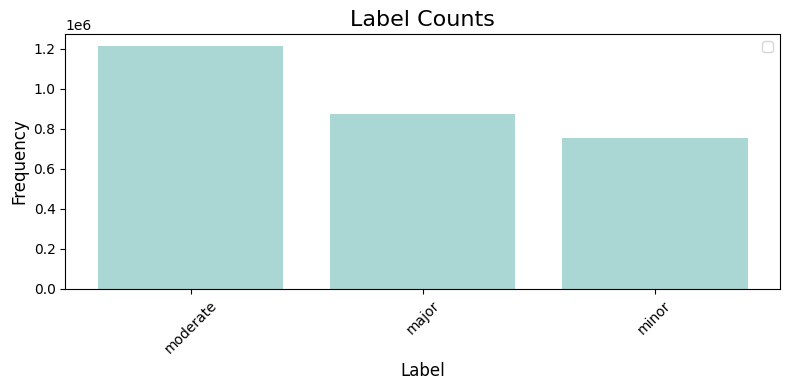

In [27]:
label_counts = ddi['label_meaning'].value_counts()
plt.figure(figsize=(8, 4))
plt.bar(label_counts.index, label_counts, color='#aad7d4')
plt.title('Label Counts', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

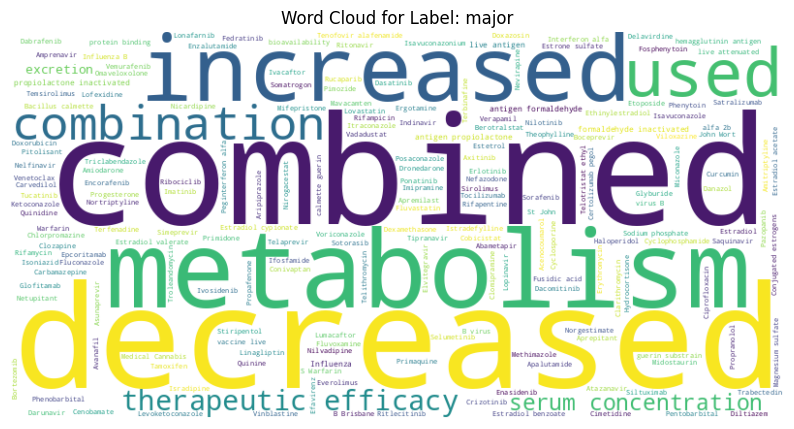

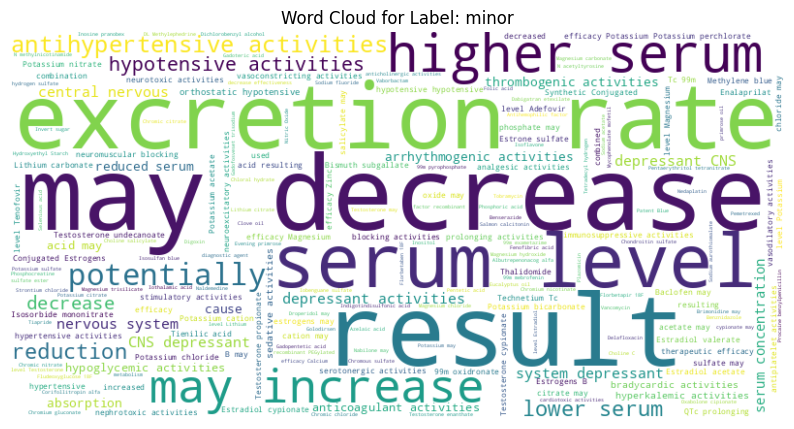

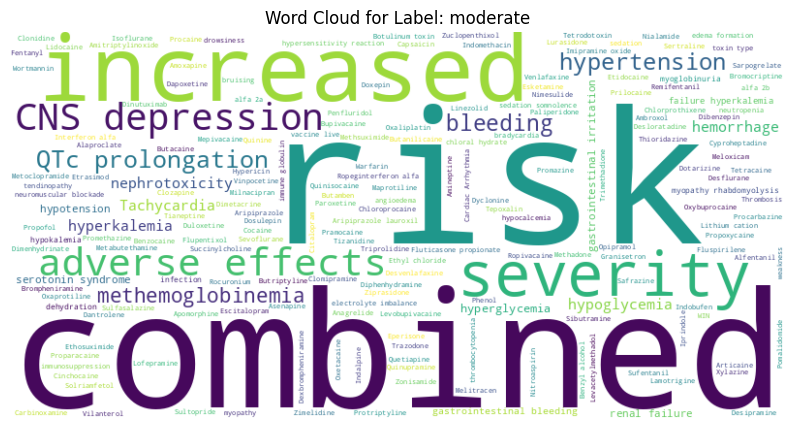

In [28]:
grouped = ddi.groupby('label_meaning')['interaction_description'].apply(lambda x: ' '.join(x)).reset_index()

def generate_word_cloud(text, label):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label: {label}')
    plt.show()

for index, row in grouped.iterrows():
    label = row['label_meaning']
    text = row['interaction_description']
    generate_word_cloud(text, label)

In [21]:
# Drop duplicated pairs
print(f'Shape before removing duplicates: {ddi.shape}')
ddi[['primary_id', 'interacting_drug_id']] = ddi.apply(lambda x: sorted([x['primary_id'], x['interacting_drug_id']]), axis=1, result_type='expand')
ddi.drop_duplicates(subset=['primary_id', 'interacting_drug_id'], inplace=True)
print(f'Shape after removing duplicates: {ddi.shape}')

Shape before removing duplicates: (2839610, 9)
Shape after removing duplicates: (1420072, 9)


In [23]:
db_smiles = pd.read_csv('../../data/db_smiles.csv')
db_smiles.drop(columns=['Unnamed: 0', 'index'], inplace=True, errors='ignore')
db_smiles.head()

,DrugBank ID,SMILES
0,DB00001,NaN
1,DB00002,NaN
2,DB00003,NaN
3,DB00004,NaN
4,DB00005,NaN


In [25]:
db_smiles.rename(columns={'DrugBank ID': 'primary_id', 'SMILES': 'primary_smiles'}, inplace=True)
ddi = pd.merge(ddi, db_smiles, how='left', on='primary_id')
db_smiles.rename(columns={'primary_id': 'interacting_drug_id', 'primary_smiles': 'interaction_drug_smiles'}, inplace=True)
ddi = pd.merge(ddi, db_smiles, how='left', on='interacting_drug_id')

In [29]:
ddi.isna().sum()

primary_id                      0
interacting_drug_id             0
primary_name                    0
interacting_drug_name           0
interaction_description         0
labels                          0
label_meaning                   0
primary_smiles             146645
interaction_drug_smiles    183212
dtype: int64

In [32]:
ddi.dropna(inplace=True)

In [34]:
primary_isvalid = check_smiles_validity(ddi['primary_smiles'].unique())
interaction_drug_isvalid = check_smiles_validity(ddi['interaction_drug_smiles'].unique())

[23:10:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:10:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:10:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:10:08] Unusual charge on atom 0 number of radical electrons set to zero
[23:10:09] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[23:10:09] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
[23:10:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:10:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:10:09] Explicit valence for atom # 0 N, 4, is grea

In [35]:
primary_isvalid[primary_isvalid['Valid'] != True].count()

SMILES    5
Valid     5
dtype: int64

In [36]:
interaction_drug_isvalid[interaction_drug_isvalid['Valid'] != True].count()

SMILES    5
Valid     5
dtype: int64

In [37]:
primary_isvalid.rename(columns={'SMILES': 'primary_smiles', 'Valid': 'primary_isvalid'}, inplace=True)
interaction_drug_isvalid.rename(columns={'SMILES': 'interaction_drug_smiles', 'Valid': 'interaction_drug_isvalid'}, inplace=True)
ddi = pd.merge(ddi, primary_isvalid, how='left', on='primary_smiles')
ddi = pd.merge(ddi, interaction_drug_isvalid, how='left', on='interaction_drug_smiles')

In [39]:
ddi[(ddi['primary_isvalid'] != True) | (ddi['interaction_drug_isvalid'] != True)].count()

primary_id                  3939
interacting_drug_id         3939
primary_name                3939
interacting_drug_name       3939
interaction_description     3939
labels                      3939
label_meaning               3939
primary_smiles              3939
interaction_drug_smiles     3939
primary_isvalid             3939
interaction_drug_isvalid    3939
dtype: int64

In [40]:
ddi = ddi[(ddi['primary_isvalid'] == True) & (ddi['interaction_drug_isvalid'] == True)]
print(f'Final shape: {ddi.shape}')

Final shape: (1159513, 11)


In [41]:
ddi.to_csv('../../data/ddi_processed.csv')

## Play with RdKit

In [4]:
from rdkit.Chem import Draw, AllChem
from rdkit import Chem
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchview import draw_graph
from PIL import Image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
ddi = pd.read_csv('../../data/ddi_processed.csv')
ddi.drop(columns=['Unnamed: 0','primary_isvalid', 'interaction_drug_isvalid'], inplace=True, errors='ignore')
ddi.head()

,primary_id,interacting_drug_id,primary_name,interacting_drug_name,interaction_description,labels,label_meaning,primary_smiles,interaction_drug_smiles
0,DB00006,DB06605,Bivalirudin,Apixaban,Apixaban may increase the anticoagulant activi...,2,minor,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,COC1=CC=C(C=C1)N1N=C(C(N)=O)C2=C1C(=O)N(CC2)C1...
1,DB00006,DB06695,Bivalirudin,Dabigatran etexilate,Dabigatran etexilate may increase the anticoag...,2,minor,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,CCCCCCOC(=O)\N=C(\N)C1=CC=C(NCC2=NC3=C(C=CC(=C...
2,DB00006,DB01254,Bivalirudin,Dasatinib,The risk or severity of bleeding and hemorrhag...,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(C)C=CC=C2Cl)=CC(...
3,DB00006,DB01609,Bivalirudin,Deferasirox,The risk or severity of gastrointestinal bleed...,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,OC(=O)C1=CC=C(C=C1)N1N=C(N=C1C1=CC=CC=C1O)C1=C...
4,DB00006,DB01586,Bivalirudin,Ursodeoxycholic acid,The risk or severity of bleeding and bruising ...,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,[H][C@@]1(CC[C@@]2([H])[C@]3([H])[C@@H](O)C[C@...


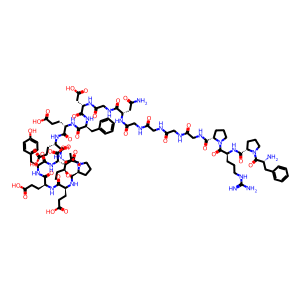

In [7]:
smile = ddi.iloc[0]['primary_smiles']
m = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(m)
img

In [8]:
def create_fingerprints(smiles_list, prefix):
    molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in molecules]
    fingerprint_arrays = [np.array(fingerprint) for fingerprint in fingerprints]
    res_df = pd.DataFrame({
        f'{prefix}_smiles': smiles_list,
        f'{prefix}_fingerprint': fingerprint_arrays
    })
    return res_df

In [9]:
primary_fingerprint_df = create_fingerprints(ddi['primary_smiles'].unique(), 'primary')
interaction_drug_fingerprint_df = create_fingerprints(ddi['interaction_drug_smiles'].unique(), 'interaction_drug')

[12:23:48] Unusual charge on atom 0 number of radical electrons set to zero
[12:23:51] Unusual charge on atom 0 number of radical electrons set to zero


103


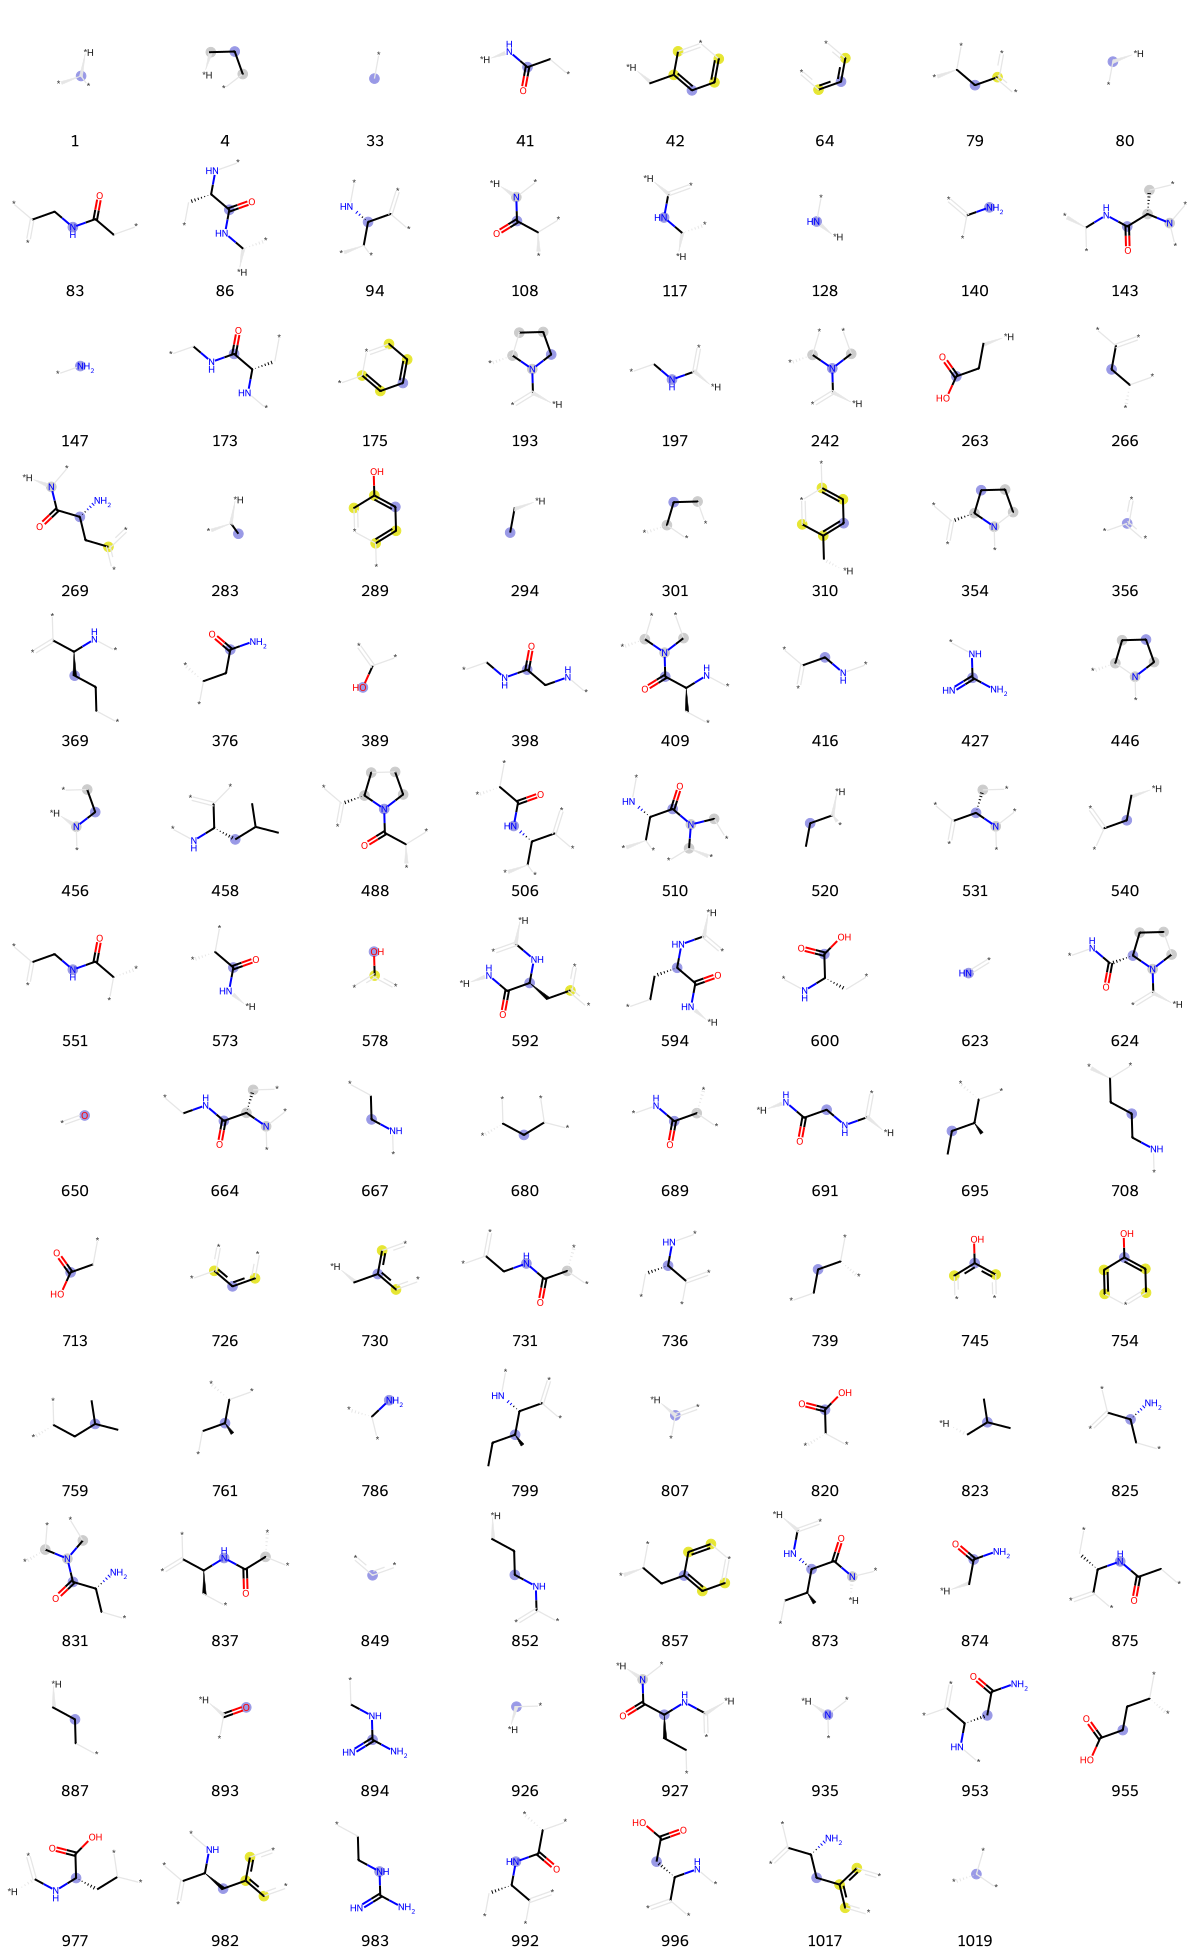

In [10]:
smile = ddi.iloc[0]['primary_smiles']
mol = Chem.MolFromSmiles(smile)
bi1 = {}
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi1)
print(len(list(fp1.GetOnBits())))
tpls1 = [(mol, x, bi1) for x in fp1.GetOnBits()]
Draw.DrawMorganBits(tpls1[:], molsPerRow=8, legends=[str(x) for x in fp1.GetOnBits()][:])

In [11]:
ddi = pd.merge(ddi, primary_fingerprint_df, how='left', on='primary_smiles')
ddi = pd.merge(ddi, interaction_drug_fingerprint_df, how='left', on='interaction_drug_smiles')

ddi['concat_fingerprints'] = ddi.apply(
    lambda row: np.concatenate([row['primary_fingerprint'], row['interaction_drug_fingerprint']]), axis=1
)
ddi.head()

,primary_id,interacting_drug_id,primary_name,interacting_drug_name,interaction_description,labels,label_meaning,primary_smiles,interaction_drug_smiles,primary_fingerprint,interaction_drug_fingerprint,concat_fingerprints
0,DB00006,DB06605,Bivalirudin,Apixaban,Apixaban may increase the anticoagulant activi...,2,minor,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,COC1=CC=C(C=C1)N1N=C(C(N)=O)C2=C1C(=O)N(CC2)C1...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DB00006,DB06695,Bivalirudin,Dabigatran etexilate,Dabigatran etexilate may increase the anticoag...,2,minor,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,CCCCCCOC(=O)\N=C(\N)C1=CC=C(NCC2=NC3=C(C=CC(=C...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,DB00006,DB01254,Bivalirudin,Dasatinib,The risk or severity of bleeding and hemorrhag...,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(C)C=CC=C2Cl)=CC(...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,DB00006,DB01609,Bivalirudin,Deferasirox,The risk or severity of gastrointestinal bleed...,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,OC(=O)C1=CC=C(C=C1)N1N=C(N=C1C1=CC=CC=C1O)C1=C...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,DB00006,DB01586,Bivalirudin,Ursodeoxycholic acid,The risk or severity of bleeding and bruising ...,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,[H][C@@]1(CC[C@@]2([H])[C@]3([H])[C@@H](O)C[C@...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
ddi['len_fingerprints'] = ddi['concat_fingerprints'].apply(
    lambda x: len(x)
)
print(f'Length of combined fingerprints: {ddi["len_fingerprints"].unique()}')

Length of combined fingerprints: [2048]


### First Basic Model

In [13]:
features = np.memmap('features.dat', dtype='float16', mode='w+', shape=(len(ddi), 2048))
labels = np.memmap('labels.dat', dtype='float16', mode='w+', shape=(len(ddi),))

for i, row in enumerate(ddi['concat_fingerprints']):
    features[i] = row
labels[:] = ddi['labels']

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

In [14]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_final_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_final_tensor = torch.tensor(y_test_final, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_final_tensor, y_test_final_tensor)

batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class DDI_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DDI_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

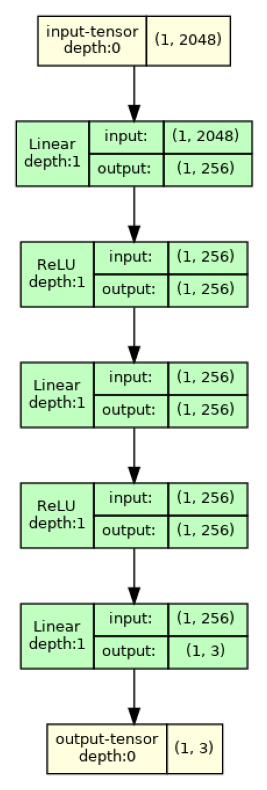

In [24]:
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = 3

dummy_model = DDI_NN(input_dim, hidden_dim, output_dim)
dummy_input = torch.randn(1, 2048)

model_graph = draw_graph(
    dummy_model,
    input_data=(dummy_input),
    expand_nested=True,
    save_graph=True,
    filename="drug_interaction_model_basic", 
    directory="./",
)

image = Image.open("drug_interaction_model_basic.png")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

Epoch [1/100], Train Loss: 0.5180, Val Loss: 0.3449, Val Accuracy: 86.94%
Epoch [2/100], Train Loss: 0.2798, Val Loss: 0.2649, Val Accuracy: 89.94%
Epoch [3/100], Train Loss: 0.2094, Val Loss: 0.2312, Val Accuracy: 91.36%
Epoch [4/100], Train Loss: 0.1694, Val Loss: 0.2147, Val Accuracy: 92.01%
Epoch [5/100], Train Loss: 0.1422, Val Loss: 0.2036, Val Accuracy: 92.49%
Epoch [6/100], Train Loss: 0.1233, Val Loss: 0.2003, Val Accuracy: 92.73%
Epoch [7/100], Train Loss: 0.1078, Val Loss: 0.2032, Val Accuracy: 92.91%
Epoch [8/100], Train Loss: 0.0964, Val Loss: 0.1978, Val Accuracy: 93.14%
Epoch [9/100], Train Loss: 0.0862, Val Loss: 0.2025, Val Accuracy: 93.24%
Epoch [10/100], Train Loss: 0.0790, Val Loss: 0.2072, Val Accuracy: 93.32%
Epoch [11/100], Train Loss: 0.0715, Val Loss: 0.2107, Val Accuracy: 93.32%
Validation accuracy converged (Δ < 0.01%). Stopping early at epoch 11.


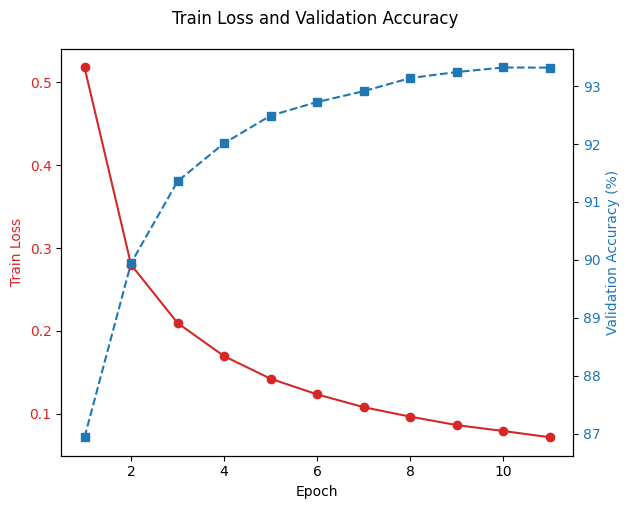

In [21]:
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = 3
model = DDI_NN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
val_accuracies = []
early_stop_threshold = 0.01 

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
    
    if epoch > 0 and abs(val_accuracies[-1] - val_accuracies[-2]) < early_stop_threshold:
        print(f"Validation accuracy converged (Δ < {early_stop_threshold}%). Stopping early at epoch {epoch+1}.")
        break


fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:red')
ax1.plot(range(1, min(epoch + 2, num_epochs + 1)), train_losses, marker='o', linestyle='-', color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy (%)', color='tab:blue')
ax2.plot(range(1, min(epoch + 2, num_epochs + 1)), val_accuracies, marker='s', linestyle='--', color='tab:blue', label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')
fig.tight_layout()
fig.suptitle('Train Loss and Validation Accuracy', y=1.05)
plt.show()

In [22]:
model.eval()
total_test_loss = 0
correct = 0
total = 0

with torch.no_grad(): 
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

test_accuracy = correct / total
print(f"Validation Loss: {total_test_loss / len(test_loader):.4f}")
print(f"Validation Accuracy: {test_accuracy:.4f}")

Validation Loss: 0.2045
Validation Accuracy: 0.9340


In [23]:
torch.save(model.state_dict(), "drug_interaction_model_basic.pth")

### More Complex Model

In [14]:
features_primary = np.memmap('features_primary.dat', dtype='float16', mode='w+', shape=(len(ddi), 1024))
features_interaction = np.memmap('features_interaction.dat', dtype='float16', mode='w+', shape=(len(ddi), 1024))
labels = np.memmap('labels.dat', dtype='float16', mode='w+', shape=(len(ddi),))

for i, (fp1, fp2) in enumerate(zip(ddi['primary_fingerprint'], ddi['interaction_drug_fingerprint'])):
    features_primary[i] = fp1
    features_interaction[i] = fp2
labels[:] = ddi['labels']

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    features_primary, features_interaction, labels, test_size=0.2, random_state=42
)

X1_val, X1_test_final, X2_val, X2_test_final, y_val, y_test_final = train_test_split(
    X1_test, X2_test, y_test, test_size=0.5, random_state=42
)

In [15]:
X1_train_tensor = torch.tensor(X1_train, dtype=torch.float32)
X2_train_tensor = torch.tensor(X2_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X1_val_tensor = torch.tensor(X1_val, dtype=torch.float32)
X2_val_tensor = torch.tensor(X2_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X1_test_final_tensor = torch.tensor(X1_test_final, dtype=torch.float32)
X2_test_final_tensor = torch.tensor(X2_test_final, dtype=torch.float32)
y_test_final_tensor = torch.tensor(y_test_final, dtype=torch.long)

train_dataset = TensorDataset(X1_train_tensor, X2_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X1_val_tensor, X2_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X1_test_final_tensor, X2_test_final_tensor, y_test_final_tensor)

batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
class DrugInteractionModel(nn.Module):
    def __init__(self):
        super(DrugInteractionModel, self).__init__()
        
        # Encoder of each fingerprint
        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        # Merging Layer + Classifier
        self.fc_merge = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
        )

    def forward(self, drug1, drug2):
        encoded_drug1 = self.encoder(drug1)
        encoded_drug2 = self.encoder(drug2)
        merged = torch.cat((encoded_drug1, encoded_drug2), dim=1)
        out = self.fc_merge(merged)
        return out

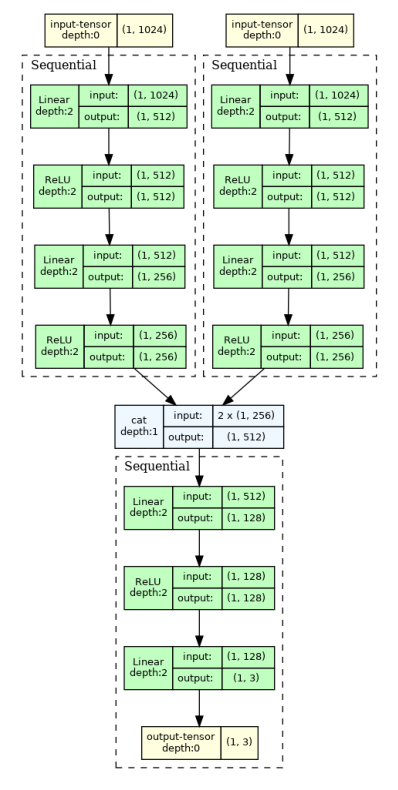

In [27]:
dummy_model = DrugInteractionModel()
dummy_input_1 = torch.randn(1, 1024)
dummy_input_2 = torch.randn(1, 1024)

model_graph = draw_graph(
    dummy_model,
    input_data=(dummy_input_1, dummy_input_2),
    expand_nested=True,
    save_graph=True,
    filename="drug_interaction_model", 
    directory="./",
)

image = Image.open("drug_interaction_model.png")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

Epoch [1/100], Train Loss: 0.5770, Val Loss: 0.4730, Val Accuracy: 80.58%
Epoch [2/100], Train Loss: 0.4137, Val Loss: 0.3677, Val Accuracy: 85.66%
Epoch [3/100], Train Loss: 0.3299, Val Loss: 0.3055, Val Accuracy: 88.31%
Epoch [4/100], Train Loss: 0.2764, Val Loss: 0.2599, Val Accuracy: 90.07%
Epoch [5/100], Train Loss: 0.2376, Val Loss: 0.2252, Val Accuracy: 91.46%
Epoch [6/100], Train Loss: 0.2090, Val Loss: 0.2019, Val Accuracy: 92.35%
Epoch [7/100], Train Loss: 0.1862, Val Loss: 0.1860, Val Accuracy: 93.10%
Epoch [8/100], Train Loss: 0.1693, Val Loss: 0.1727, Val Accuracy: 93.57%
Epoch [9/100], Train Loss: 0.1563, Val Loss: 0.1629, Val Accuracy: 93.92%
Epoch [10/100], Train Loss: 0.1456, Val Loss: 0.1575, Val Accuracy: 94.19%
Epoch [11/100], Train Loss: 0.1368, Val Loss: 0.1491, Val Accuracy: 94.50%
Epoch [12/100], Train Loss: 0.1286, Val Loss: 0.1446, Val Accuracy: 94.67%
Epoch [13/100], Train Loss: 0.1222, Val Loss: 0.1434, Val Accuracy: 94.70%
Epoch [14/100], Train Loss: 0.1158

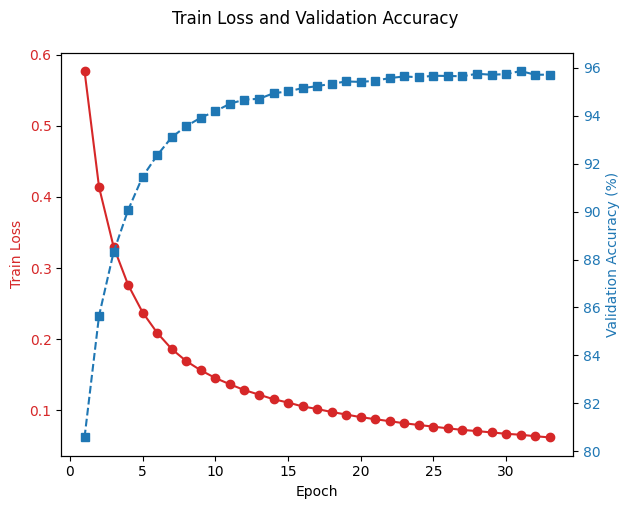

In [19]:
model = DrugInteractionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
val_accuracies = []
early_stop_threshold = 0.01 


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X1, batch_X2, batch_y in train_loader:
        batch_X1, batch_X2, batch_y = batch_X1.to(device), batch_X2.to(device), batch_y.to(device)
        outputs = model(batch_X1, batch_X2)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X1, batch_X2, batch_y in val_loader:
            batch_X1, batch_X2, batch_y = batch_X1.to(device), batch_X2.to(device), batch_y.to(device)
            outputs = model(batch_X1, batch_X2)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    epoch_accuracy = 100 * correct / total
    val_accuracies.append(epoch_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {epoch_accuracy:.2f}%")
    
    if epoch > 0 and abs(val_accuracies[-1] - val_accuracies[-2]) < early_stop_threshold:
        print(f"Validation accuracy converged (Δ < {early_stop_threshold}%). Stopping early at epoch {epoch+1}.")
        break


fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:red')
ax1.plot(range(1, min(epoch + 2, num_epochs + 1)), train_losses, marker='o', linestyle='-', color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy (%)', color='tab:blue')
ax2.plot(range(1, min(epoch + 2, num_epochs + 1)), val_accuracies, marker='s', linestyle='--', color='tab:blue', label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')
fig.tight_layout()
fig.suptitle('Train Loss and Validation Accuracy', y=1.05)
plt.show()

In [22]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch_X1, batch_X2, batch_y in test_loader:
        batch_X1, batch_X2, batch_y = batch_X1.to(device), batch_X2.to(device), batch_y.to(device)
        outputs = model(batch_X1, batch_X2)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1300
Test Accuracy: 95.7284


In [28]:
torch.save(model.state_dict(), "drug_interaction_model.pth")

### Play with loaded models

In [ ]:
model = DrugInteractionModel()
model.load_state_dict(torch.load("drug_interaction_model.pth"))
model.eval() 
print("Model loaded successfully from 'drug_interaction_model.pth'")